# 从零开始的线性回归

## 一次方程梯度下降拟合

In [1]:
%matplotlib inline
import torch
import numpy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
numpy.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4, sci_mode=False)

### 数据生成

In [2]:
def artificialData(weights, bias, dataSize, xMean=0., xStd=1., yMean=0., yStd=1.):
    X = torch.normal(mean=xMean, std=xStd, size=(dataSize, len(weights)))
    y = torch.matmul(X, weights) + bias
    y[:] = y + torch.normal(yMean, yStd, y.shape)
    return X, y.reshape((-1, 1))

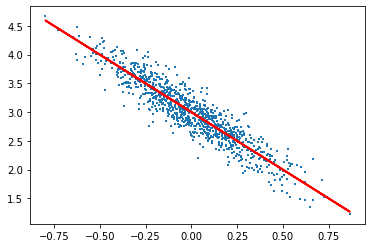

In [3]:
trueWeights = torch.tensor([-2.])
trueBias = torch.tensor(3.)
weightSize = trueWeights.shape
features, labels = artificialData(trueWeights, trueBias, 1000, xStd=0.25, yStd=0.2)
plt.scatter(features, labels, marker='+', s=5)
plt.plot(features, torch.matmul(features, trueWeights)+trueBias, c='r', linewidth=2)
plt.show()

### 工具函数

In [4]:
def dataIteration(batchSize, features, labels):
    dataSize = len(features)
    indices = list(range(dataSize))
    random.shuffle(indices)
    for i in range(0, dataSize, batchSize):
        batchIndices = torch.tensor(indices[i:min(i+batchSize, dataSize)])
        yield features[batchIndices], labels[batchIndices]

def linreg(X, w, b):
    return torch.matmul(X, w)+b

def squaredLoss(yHat, y):
    return (yHat - y.reshape(yHat.shape))**2/2

def sgd(params, lr, batchSize):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batchSize
            param.grad.zero_()

### 训练过程

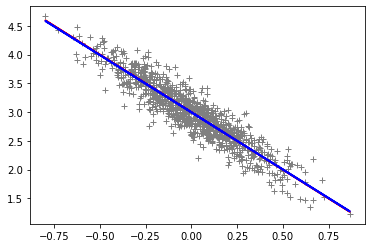

In [5]:
lr = 0.02
epochs = 80
net = linreg
loss = squaredLoss
batchSize = 10

w = torch.normal(mean=0, std=0.01, size=weightSize, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

logWeights = []
logBias = []

# 训练过程
for epoch in range(epochs):
    for X, y in dataIteration(batchSize, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batchSize)
    with torch.no_grad():
        logWeights.append(w.clone())
        logBias.append(b.clone())

# 输出最终结果
with torch.no_grad():
    plt.plot(features, labels, '+', linewidth=1, c='grey')
    plt.plot(features, torch.matmul(features, trueWeights)+trueBias, c='r', linewidth=2)
    plt.plot(features, torch.matmul(features, logWeights[-1])+logBias[-1], c='b', linewidth=2)
plt.show()
plt.close()

### 拟合动画

In [6]:
fig = plt.figure(figsize=(10, 7.5), dpi=120)
ims = []

plt.scatter(features, labels, marker='o', s=5, c='grey')
plt.plot(features, torch.matmul(features, trueWeights)+trueBias, c='r', linewidth=2)

lineHat = plt.plot(features, torch.matmul(features, logWeights[0])+logBias[0], c='b', linewidth=2)[0]

def update(epoch):
    lineHat.set_data(features, torch.matmul(features, logWeights[epoch])+logBias[epoch])

ani = animation.FuncAnimation(fig, update, frames=numpy.arange(1, epochs), interval=100, repeat=True, repeat_delay=3000)
ani.save('note03--linReg.gif', writer='pillow')
plt.close()

## 练习: 二次函数梯度下降拟合

In [7]:
%matplotlib inline
import torch
import numpy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
numpy.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4, sci_mode=False)

### 数据生成

In [8]:
def artificialData(weights, dataSize, xNoise=0.1, yNoise=0.1):
    a, b, _ = weights
    weights = weights.reshape((-1, 1))
    X = torch.normal(mean=-b/(2*a), std=1/a, size=(dataSize, 1))
    XNoise = torch.normal(mean=0, std=xNoise, size=X.shape)
    features = torch.concat(((X+XNoise)**2, X+XNoise, torch.full_like(X, 1.)), dim=1)
    y = torch.mm(features, weights)
    y += torch.normal(mean=0, std=yNoise, size=y.shape)
    return X, y

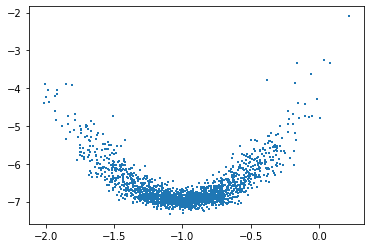

In [9]:
trueWeights = torch.tensor([3., 6., -4.])
dataSize = 2000
features, labels = artificialData(trueWeights, dataSize)

fig = plt.figure()
plt.scatter(features, labels, marker='+', s=3)
plt.show()

### 工具函数

In [10]:
def dataIteration(batchSize, features, labels):
    dataSize = len(labels)
    indices = list(range(dataSize))
    random.shuffle(indices)
    for i in range(0, dataSize, batchSize):
        batchIndices = torch.tensor(indices[i:min(i+batchSize, dataSize)])
        yield features[batchIndices], labels[batchIndices]

def quad(features, weights):
    return torch.mm(torch.concat((features**2, features, torch.full_like(features, 1.)), dim=1), weights)

def squareLoss(yHat, y):
    return (yHat - y.reshape(yHat.shape))**2 / 2

def sgd(params, lr, batchSize):
    with torch.no_grad():
        params -= lr * params.grad / batchSize
        params.grad.zero_() 

### 训练过程

In [11]:
lr = 0.1
batchSize = 100
loss = squareLoss
net = quad

weights = torch.zeros((3, 1), requires_grad=True)
logWeights = []

epochs = 450

for epoch in range(epochs):
    for X, y in dataIteration(batchSize, features, labels):
        l = loss(net(X, weights), y)
        l.sum().backward()
        sgd(weights, lr, batchSize)
    with torch.no_grad():
        logWeights.append(weights.clone())

print(weights)

tensor([[ 2.9191],
        [ 5.8166],
        [-4.0660]], requires_grad=True)


### 拟合动画

In [12]:
fig = plt.figure(figsize=(10, 7.5), dpi=120)
ims = []
a, b, c = trueWeights
minNum = -b/(2*a)-3/a
maxNum = -b/(2*a)+3/a

trueX = numpy.linspace(minNum, maxNum, 100)
trueY = a*trueX**2+b*trueX+c

plt.scatter(features, labels, marker='o', s=5, c='grey')
plt.plot(trueX, trueY, c='r', linewidth=2)

lineHat = plt.plot(trueX, logWeights[0][0]*trueX**2+logWeights[0][1]*trueX+logWeights[0][2], c='b', linewidth=2)[0]

def update(epoch):
    lineHat.set_data(trueX, logWeights[epoch][0]*trueX**2+logWeights[epoch][1]*trueX+logWeights[epoch][2])

ani = animation.FuncAnimation(fig, update, frames=numpy.arange(1, epochs), interval=30, repeat=True, repeat_delay=3000)
ani.save('note03--linReg2.gif', writer='pillow')
plt.close()